# An implementation of the single period Kyle model

Implemented by Paul Friedrich, 2019, ETH Zürich.


# Initialization

Needed python packages: Keras, TensorFlow, Matplotlib, Numpy, Scipy.
If using a CPU, note the comments in the first cell.

In [1]:
## Import modules
import os

# COMMENT THIS OUT IF USING TENSORFLOW-GPU
# The line below forces CPU usage. In this file, that is faster than using a GPU, 
# probably due to the relatively small net size and large CPU/GPU handoff performance cost 
# due to the requirement of batch size =1.
os.environ['CUDA_VISIBLE_DEVICES'] = '-1' 

import time
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import keras
import scipy.stats as ss
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Lambda, Dropout
from keras import backend as K
from keras.callbacks import History
from keras.utils import plot_model

Using TensorFlow backend.


# Configuration

A number of configuration options can be chosen here. Note the comments to see what the possibilities are.

Control which distributions to use for noise trader orders Y and final price Z using the ```whichdist_y``` and ```whichdist_z``` variables. Options are 'normal', 'laplace', 'gumbel', 'gamma', 'gammacent' and 'bimodal'. We suggest leaving y to be normally distributed and only altering Z.

Choices about the parameters are made by passing the appropriate string to the ```whichconfig``` variable. Available configurations are given by a tuple ($\mu_z,$ $\sigma_z,$ $\sigma_y$):

- 'cent': 0, 2, 1.
- 'non-cent': 0.5, 2, 1.
- 'non-cent-gamma': 1, $\sqrt{2}$, 1

Control the amount of training epochs for the insider and market maker with the variables ```epochs_I``` and ```epochs_MM``` (default: 3 both).

Control the sample size of both the insider and market maker training data using the variables ```n_I``` and ```n_MM``` (default: 5000 both).

Control the amount of maximum training loops with the variable ```N_loops``` (default: 20). Convergence usually occurs between loops 10-15.

Control the type of the initial insider order function which is used for training the market maker model in the first training loop using the variable ```whichstart```. Available options are:
- 'linstart' for a start of I_initial(z) = intercept_equilibrium + slope_equilibrium * z. This represents an insider that has reached the equilibrium.
- 'noisestart' for a start of I_initial(z) = a single sample from $\mathcal{N}(0, \sigma_y) \sim Y$. (default)
- 'expstart' for a start of I_initial(z) = intercept_equilibrium + slope_equilibrium * 10 * $(e^{0.1 z} - 1)$. This represents an insider that is very similar to the equilibrium but not linear.

Control the size of the transaction cost using the ```transaction_cost``` variable. Good values to use are 0 (no transaction cost, default), 0.5, 1, 1.5.

In [3]:
#### ADJUST THIS EACH RUN ####
runnumber = 9999
transaction_cost = 0
epochs_I = 3
epochs_MM = 3
n_I = 5000
n_MM = 5000
N_loops = 20
whichconfig='cent'
whichstart='noisestart'
whichactivations='relu'
whichdist_z='normal'  
whichdist_y='normal'
###############################

whichdist = whichdist_z if whichdist_z==whichdist_y else whichdist_z+whichdist_y
runname='run'+str(runnumber)


## Defines mean/stddevs
def get_dist_constants(config_name):
    if config_name=='cent': 
        return(0, 2, 1)
    elif config_name=='non-cent': 
        return(0.5, 2, 1)
    elif config_name=='non-cent-gamma': 
        return(1, np.sqrt(2), 1)
    else: raise NameError('Invalid dist. config chosen')

# Defining constants. mu==mean, sigma==stddev.
mu_z, sigma_z, sigma_y = get_dist_constants(whichconfig)
    
# Calculate the theoretical constants for linear predictions. For centered gamma: intercept=0 since mean=0.
slope_I = sigma_y/sigma_z
intercept_I = 0 if whichdist_z=='gammacent' else -mu_z*sigma_y/sigma_z
intercept_MM = 0 if whichdist_z=='gammacent' else mu_z
slope_MM = sigma_z/(2*sigma_y)


# Initialize insider obj function
def insider_order(x):
    if whichstart=='linstart':
        return(intercept_I+slope_I*x)
    elif whichstart=='noisestart':
        return(np.random.normal(loc=0,scale=sigma_y,size=np.size(x)))
    elif whichstart=='expstart':
        return(intercept_I + slope_I * 10*(np.exp(0.1*x) - 1))
    else:
        raise NameError('Invalid starting order function chosen. Adjust "whichstart".')


# Draws samples
def sample_from_dist(dist, param_1, param_2, sample_size):
    if dist=='normal':
        return(np.array(np.random.normal(loc=param_1, scale=param_2, size=sample_size)))
    elif dist=='laplace':
        return(np.array(np.random.laplace(loc=param_1, scale=param_2/np.sqrt(2), size=sample_size)))
    elif dist=='gumbel':
        return(np.array(np.random.gumbel(loc=param_1-param_2*np.sqrt(6)*np.euler_gamma/np.pi, scale=param_2*np.sqrt(6)/np.pi, size=sample_size)))
    elif dist=='gamma':
        return(np.array(np.random.gamma(shape=param_2**2 / param_1, scale=param_1**2 / param_2**2, size=sample_size)))
    elif dist=='gammacent':
        return(np.array(np.random.gamma(shape=param_2**2 / param_1, scale=param_1**2 / param_2**2, size=sample_size)-mu_z))
    elif dist=='bimodal':
        p_z_mix = 0.5
        mu_z_1 = -2
        mu_z_2 = 2
        sigma_z_1 = 1
        sigma_z_2 = 1
        def mu_mixed(p, mu_1, mu_2):
            return(p*mu_1 + (1-p)*mu_2)

        def sigma_mixed(p, mu_1, mu_2, sigma_1, sigma_2):
            return(np.sqrt(p*(sigma_1**2 + (mu_1-mu_mixed(p, mu_1, mu_2))**2) + (1-p)*(sigma_2**2 + (mu_2-mu_mixed(p, mu_1, mu_2))**2)))
        mu_z = mu_mixed(p_z_mix, mu_z_1, mu_z_2)
        sigma_z = sigma_mixed(p_z_mix, mu_z_1, mu_z_2, sigma_z_1, sigma_z_2)
        comps = np.random.choice((0,1),size=sample_size,p=(p_z_mix,1-p_z_mix))
        mus = [(mu_z_1,mu_z_2)[i] for i in comps]
        sigmas = [(sigma_z_1,sigma_z_2)[i] for i in comps]
        gaussians=np.random.normal(size=sample_size)
        return(np.array(gaussians*sigmas+mus))
    else:
        raise NameError(f'Invalid distribution chosen. Adjust whichdist_z/y.')        


# Define plotting function
def model_plotting(data, slope, intercept, name):
    data_sorted = np.sort(data)
    data_min = data_sorted[0]
    data_max = data_sorted[-1]
    data_test = np.linspace(data_min-np.linalg.norm(data_min-data_max)/2, data_max+np.linalg.norm(data_min-data_max)/2,num=1000)
    dummy = np.zeros(np.size(data_sorted))
    P_true = data_test*slope + intercept
    if name=='MM':
        P_predicted = MM_model.predict([data_test,np.zeros(1000)])
        plt.plot(data_test, P_true, color='r')
        plt.plot(data_test, P_predicted, linestyle='-',color='g')
        plt.scatter(data_sorted, MM_model.predict([data_sorted, dummy]), marker='|', color='g')
        plt.xlabel('Total Order x+y')
        plt.ylabel('Market Price P(x+y)')
    else:
        P_predicted = insider_model.predict([data_test,np.zeros(1000)])
        plt.plot(data_test, P_true, color='r')
        plt.plot(data_test, P_predicted, linestyle='-',color='g')
        plt.scatter(data_sorted, insider_model.predict([data_sorted, dummy]), marker='|', color='g')
        plt.xlabel('End-of-period price z')
        plt.ylabel('Insider order x(z)')
    plt.legend(['Predicted linear behavior','NN output'])
    plt.title(f'{name}, N={i+1}')

# Model training

The model will automatically stop training if a sufficient goodness-of-fit is reached. Alternatively, after 7 iterations, it will ask whether you want to prematurely stop it after every iteration. Answering 'y', 'yes', 's', 'stop' will stop training, for all other inputs the model continues training.

Loop 1 out of 20
Instructions for updating:
Colocations handled automatically by placer.
%%% Training MM model %%%
Instructions for updating:
Use tf.cast instead.
Epoch 1/3
5000/5000 [==============================] - 2s 499us/step - loss: 4.1003 - acc: 0.9996
Epoch 2/3
5000/5000 [==============================] - 2s 420us/step - loss: 4.0904 - acc: 0.9998
Epoch 3/3
5000/5000 [==============================] - 2s 422us/step - loss: 4.0899 - acc: 1.0000
%%% Training Insider model %%%
Epoch 1/3
5000/5000 [==============================] - 2s 464us/step - loss: -93.0696 - acc: 0.0644
Epoch 2/3
5000/5000 [==============================] - 2s 436us/step - loss: -1415.6363 - acc: 0.0016
Epoch 3/3
5000/5000 [==============================] - 2s 439us/step - loss: -7632.9072 - acc: 0.0014


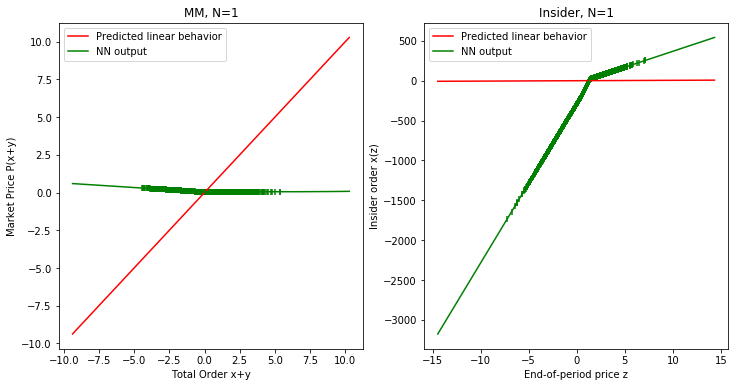

Total runtime: 00:00:14
MM slope: -0.02512230316230322 (1.0); MM intercept: 0.07445404407155577 (0)
I slope: 166.13658076125094 (0.5); I intercept: -324.1468608242456 (0.0)
Loop 2 out of 20
%%% Training MM model %%%
Epoch 1/3
5000/5000 [==============================] - 2s 471us/step - loss: 27.4512 - acc: 0.1966
Epoch 2/3
5000/5000 [==============================] - 2s 439us/step - loss: 0.0740 - acc: 0.2258
Epoch 3/3
5000/5000 [==============================] - 2s 437us/step - loss: 0.0399 - acc: 0.2088
%%% Training Insider model %%%
Epoch 1/3
5000/5000 [==============================] - 2s 486us/step - loss: -7.8902 - acc: 0.1532
Epoch 2/3
5000/5000 [==============================] - 2s 454us/step - loss: -16.9035 - acc: 0.0122
Epoch 3/3
5000/5000 [==============================] - 2s 453us/step - loss: -22.3457 - acc: 0.0082


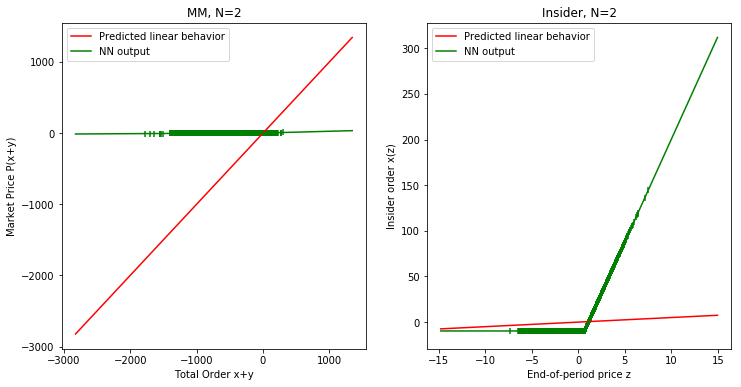

Total runtime: 00:00:29
MM slope: 0.005700640897969643 (1.0); MM intercept: 1.856957631576941 (0)
I slope: 8.29994433538599 (0.5); I intercept: 1.9359519034157489 (0.0)
Loop 3 out of 20
%%% Training MM model %%%
Epoch 1/3
5000/5000 [==============================] - 2s 486us/step - loss: 4.6448 - acc: 0.1058
Epoch 2/3
5000/5000 [==============================] - 2s 451us/step - loss: 1.3382 - acc: 0.0424
Epoch 3/3
5000/5000 [==============================] - 2s 451us/step - loss: 1.3109 - acc: 0.0400
%%% Training Insider model %%%
Epoch 1/3
5000/5000 [==============================] - 3s 505us/step - loss: -6.9433 - acc: 0.0940
Epoch 2/3
5000/5000 [==============================] - 2s 469us/step - loss: -8.9053 - acc: 0.0310
Epoch 3/3
5000/5000 [==============================] - 2s 467us/step - loss: -9.0540 - acc: 0.0918


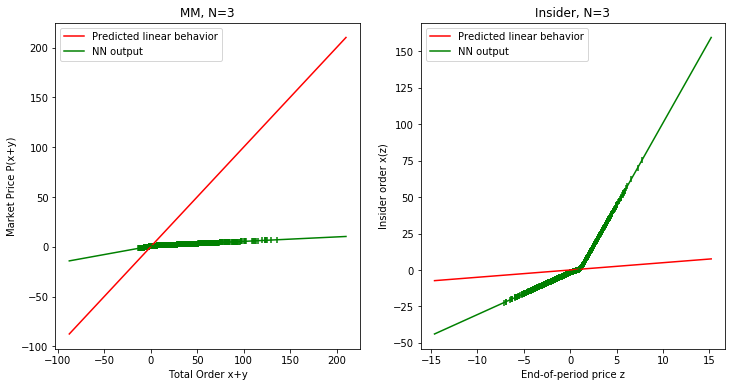

Total runtime: 00:00:44
MM slope: 0.07290915849163955 (1.0); MM intercept: -0.1547990845502495 (0)
I slope: 5.200688807600315 (0.5); I intercept: 0.9024175487520765 (0.0)
Loop 4 out of 20
%%% Training MM model %%%
Epoch 1/3
5000/5000 [==============================] - 3s 504us/step - loss: 0.2663 - acc: 0.2110
Epoch 2/3
5000/5000 [==============================] - 2s 461us/step - loss: 0.0998 - acc: 0.2044
Epoch 3/3
5000/5000 [==============================] - 2s 464us/step - loss: 0.0977 - acc: 0.2012
%%% Training Insider model %%%
Epoch 1/3
5000/5000 [==============================] - 3s 524us/step - loss: -3.8881 - acc: 0.1020
Epoch 2/3
5000/5000 [==============================] - 2s 476us/step - loss: -4.4582 - acc: 0.0650
Epoch 3/3
5000/5000 [==============================] - 2s 473us/step - loss: -4.4871 - acc: 0.0684


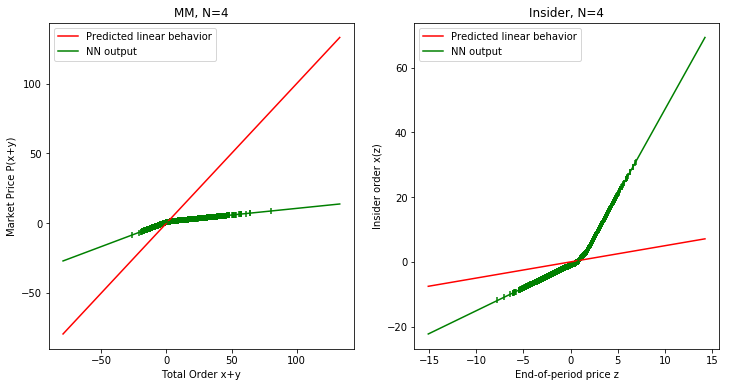

Total runtime: 00:00:59
MM slope: 0.16618137375137895 (1.0); MM intercept: -0.15394753180891044 (0)
I slope: 2.501505429244555 (0.5); I intercept: 0.33429489606338086 (0.0)
Loop 5 out of 20
%%% Training MM model %%%
Epoch 1/3
5000/5000 [==============================] - 3s 526us/step - loss: 0.4005 - acc: 0.2096
Epoch 2/3
5000/5000 [==============================] - 2s 478us/step - loss: 0.3042 - acc: 0.2330
Epoch 3/3
5000/5000 [==============================] - 2s 472us/step - loss: 0.3017 - acc: 0.2322
%%% Training Insider model %%%
Epoch 1/3
5000/5000 [==============================] - 3s 539us/step - loss: -2.1046 - acc: 0.1718
Epoch 2/3
5000/5000 [==============================] - 2s 486us/step - loss: -2.2453 - acc: 0.2162
Epoch 3/3
5000/5000 [==============================] - 2s 486us/step - loss: -2.2571 - acc: 0.2120


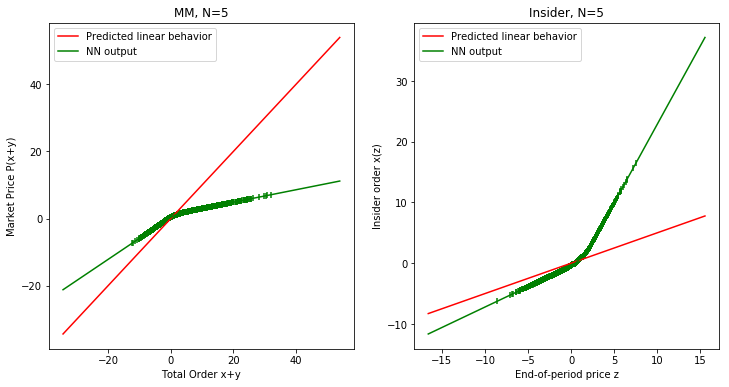

Total runtime: 00:01:15
MM slope: 0.34752065706276847 (1.0); MM intercept: -0.18202768140885117 (0)
I slope: 1.1971637201802472 (0.5); I intercept: 0.21985366016376723 (0.0)
Loop 6 out of 20
%%% Training MM model %%%
Epoch 1/3
5000/5000 [==============================] - 3s 545us/step - loss: 0.8788 - acc: 0.2002
Epoch 2/3
5000/5000 [==============================] - 2s 487us/step - loss: 0.8267 - acc: 0.2092
Epoch 3/3
5000/5000 [==============================] - 2s 486us/step - loss: 0.8209 - acc: 0.2176
%%% Training Insider model %%%
Epoch 1/3
5000/5000 [==============================] - 3s 561us/step - loss: -1.3284 - acc: 0.2590
Epoch 2/3
5000/5000 [==============================] - 3s 512us/step - loss: -1.3923 - acc: 0.2976
Epoch 3/3
5000/5000 [==============================] - 3s 504us/step - loss: -1.3944 - acc: 0.2900


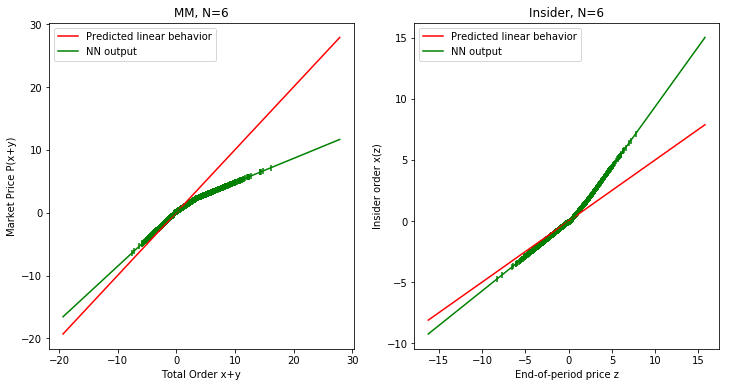

Total runtime: 00:01:32
MM slope: 0.6364939280437554 (1.0); MM intercept: -0.17075154153004193 (0)
I slope: 0.7055975257824642 (0.5); I intercept: 0.12784659138110163 (0.0)
Loop 7 out of 20
%%% Training MM model %%%
Epoch 1/3
5000/5000 [==============================] - 3s 573us/step - loss: 1.5531 - acc: 0.2300
Epoch 2/3
5000/5000 [==============================] - 3s 512us/step - loss: 1.4234 - acc: 0.2408
Epoch 3/3
5000/5000 [==============================] - 3s 507us/step - loss: 1.4256 - acc: 0.2466
%%% Training Insider model %%%
Epoch 1/3
5000/5000 [==============================] - 3s 586us/step - loss: -0.9841 - acc: 0.3200
Epoch 2/3
5000/5000 [==============================] - 3s 518us/step - loss: -1.1038 - acc: 0.3274
Epoch 3/3
5000/5000 [==============================] - 3s 520us/step - loss: -1.1035 - acc: 0.3442


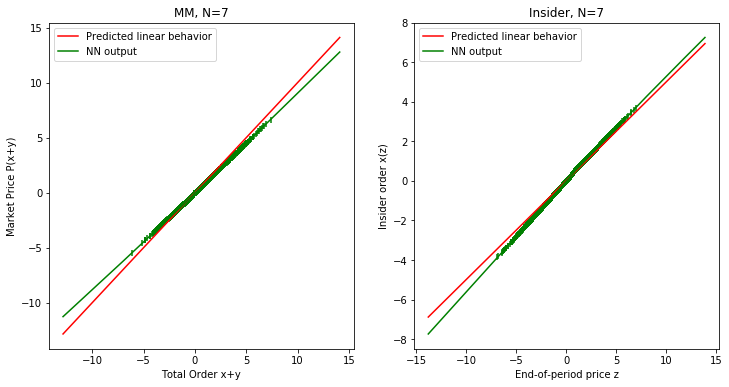

Total runtime: 00:01:49
MM slope: 0.9030329406812784 (1.0); MM intercept: -0.05503504010303997 (0)
I slope: 0.5541292161060504 (0.5); I intercept: -0.03414628410754964 (0.0)
Loop 8 out of 20
%%% Training MM model %%%
Epoch 1/3
5000/5000 [==============================] - 3s 592us/step - loss: 1.8966 - acc: 0.2638
Epoch 2/3
5000/5000 [==============================] - 3s 517us/step - loss: 1.7782 - acc: 0.2674
Epoch 3/3
5000/5000 [==============================] - 3s 516us/step - loss: 1.7738 - acc: 0.2722
%%% Training Insider model %%%
Epoch 1/3
5000/5000 [==============================] - 3s 604us/step - loss: -0.8005 - acc: 0.3632
Epoch 2/3
5000/5000 [==============================] - 3s 531us/step - loss: -0.9393 - acc: 0.4008
Epoch 3/3
5000/5000 [==============================] - 3s 530us/step - loss: -0.9398 - acc: 0.4092


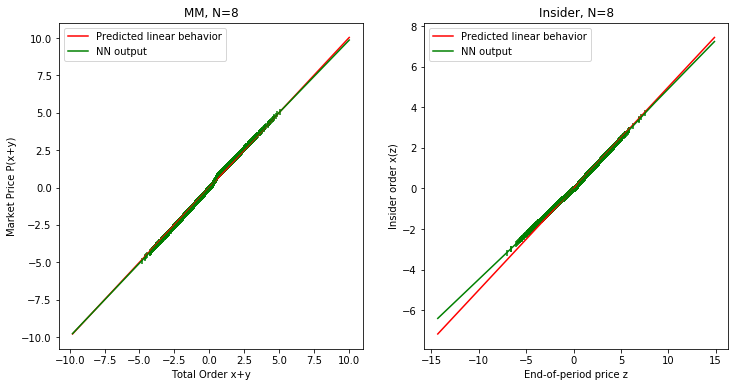

Total runtime: 00:02:07
MM slope: 1.0505601185077198 (1.0); MM intercept: -4.031004568208832e-05 (0)
I slope: 0.46887708546869156 (0.5); I intercept: 0.008189797169772632 (0.0)
%%% Sufficient goodness-of-fit is reached. %%%
Want to stop training? (y/n)
y


In [4]:
fig_list = []
t0 = time.time()

for i in range(N_loops): 
    print(f'Loop {i+1} out of {N_loops}')
    
    ### Market maker model ###
    # Build market maker sample of (y, z)'s
    y = sample_from_dist(whichdist_y, 0, sigma_y, n_MM)
    z = sample_from_dist(whichdist_z, mu_z, sigma_z, n_MM)

    # Create MM input
    x = insider_order(z).squeeze()
    total_order = x+y
        
    # MM model architecture
    in_main = Input(shape=(1,))
    in_aux = Input(shape=(1,))
    layer1_MM = Dense(10, input_shape=(1,),activation=whichactivations)(in_main)
    layer2_MM = Dense(10, activation=whichactivations)(layer1_MM)
    out_main = Dense(1)(layer2_MM)

    # MM loss func
    def MM_loss(z):
        def MM_LS(x_true, x_pred):
            return(K.square(z-x_pred))
        return(MM_LS)

    # Create and compile model
    MM_model = Model(inputs=[in_main, in_aux], 
                     outputs=out_main)
    MM_model.compile(optimizer='adam',
              loss=MM_loss(MM_model.inputs[1]),
              metrics=['accuracy'])
    dummy_y = np.zeros((n_MM,1))

    # Train model
    print('%%% Training MM model %%%')
    MM_model.fit(x=[total_order,z], y=dummy_y, epochs=epochs_MM, batch_size=1, verbose=1)
    
    # Define pricing rule
    def pricing_rule(order):
        return(MM_model([order,K.zeros(1)]))

    # Plotting MM
    fig_loop = plt.figure(i, figsize=(12,6))
    plt.subplot(121)
    model_plotting(total_order, slope_MM, intercept_MM, 'MM')
    
    
    ### Insider model ###
    # Build insider sample of z's
    z_I = sample_from_dist(whichdist_z, mu_z, sigma_z, n_I)
    y_I = sample_from_dist(whichdist_y, 0, sigma_y, n_I)
    
    # Insider model architecture
    in_main_I = Input(shape=(1,))
    in_aux_I = Input(shape=(1,))
    layer1_I = Dense(10,  activation=whichactivations)(in_main_I)
    out_main_I = Dense(1)(layer1_I)
    insider_model = Model(inputs=[in_main_I, in_aux_I], 
                  outputs=out_main_I)

    # Insider loss func.
    def insider_loss(z, y):
        def I_mean(x_true, x_pred):
            price = pricing_rule(x_pred+y)
            profits = (z-price)*x_pred - transaction_cost*K.abs(x_pred)
            return(-profits)
        return(I_mean)

    # Compile Insider Model
    insider_model.compile(optimizer='adam',
              loss=insider_loss(insider_model.input[0], insider_model.input[1]), # Call the custom loss function 
              metrics=['accuracy'])
    dummy_y = np.zeros((n_I,1))

    # Train Insider model
    print('%%% Training Insider model %%%')
    insider_model.fit(x=[z_I,y_I], y=dummy_y, epochs=epochs_I, batch_size=1, verbose=1)
    
    # Define new Insider order function
    def insider_order(price):
        return(insider_model.predict([price, np.zeros(np.size(price))]))
    
    # Plotting
    plt.subplot(122)
    model_plotting(z_I, slope_I, intercept_I, 'Insider')
    
    # Finishing plot
    fig_list.append(fig_loop)
    plt.show()

    # Taking time
    t1 = time.time()
    run_time = time.strftime('%H:%M:%S', time.gmtime(t1-t0))
    print(f'Total runtime: {run_time}')
        
    # Premature stopping 
    # regression of I 
    reg_I = ss.linregress(z_I, np.squeeze(insider_model.predict([z_I, np.zeros(np.size(z_I))])))
    stop_I = False
    if (np.abs(reg_I.slope - slope_I) < 0.075) and (np.abs(reg_I.intercept - intercept_I) < 0.5):
        stop_I = True
        
    # regression of M
    reg_MM = ss.linregress(total_order, np.squeeze(MM_model.predict([total_order, np.zeros(np.size(total_order))])))    
    stop_MM = False
    if (np.abs(reg_MM.slope - slope_MM) < 0.075) and (np.abs(reg_MM.intercept - intercept_MM) < 0.5):
        stop_MM = True 
        
    # stop condition
    print(f'MM slope: {reg_MM.slope} ({slope_MM}); MM intercept: {reg_MM.intercept} ({intercept_MM})\nI slope: {reg_I.slope} ({slope_I}); I intercept: {reg_I.intercept} ({intercept_I})')
    stop_training=[]
    if stop_I and stop_MM:
        print('%%% Sufficient goodness-of-fit is reached. %%%\nWant to stop training? (y/n)')
        stop_training = input()
    if stop_training in ['y', 'yes', 's', 'stop']:
        break

    #if (i+1)%5==0 and transaction_cost!=0: 
    if (i+1)>=7 and transaction_cost!=0:
        print(f'%%% Want to stop training prematurely? (y/n)')
        stop_training = input()
    if stop_training in ['y', 'yes', 's', 'stop']:
        break
        
        
## After loop completion  
# plotting progression
pdf = matplotlib.backends.backend_pdf.PdfPages(f'{whichstart}_{runname}_{whichconfig}_{N_loops}_{n_MM}_{epochs_MM}_{n_I}_{epochs_I}_{whichdist}_progression.pdf')
for fig in fig_list:
    pdf.savefig( fig )
pdf.close()

# Plotting final models

Generating and saving the last (and presumably best) model results.

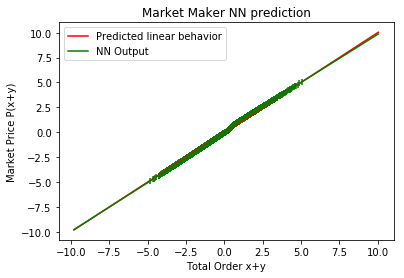

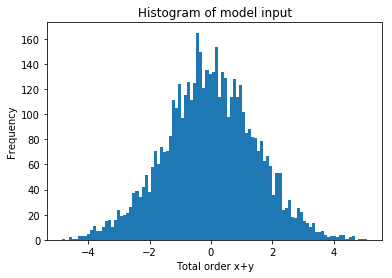

In [5]:
## plot MM
total_order_sorted = np.sort(total_order)
dummy = np.zeros(n_MM)
tot_min = total_order_sorted[0]
tot_max = total_order_sorted[-1]
tot_test = np.linspace(tot_min-np.linalg.norm(tot_min-tot_max)/2, tot_max+np.linalg.norm(tot_min-tot_max)/2,num=1000)
P_predicted = MM_model.predict([tot_test,np.zeros(1000)])
P_true = tot_test*slope_MM + intercept_MM 

plt.plot(tot_test, P_true, color='r')
plt.plot(tot_test, P_predicted, linestyle='-',color='g')
plt.scatter(total_order_sorted, MM_model.predict([total_order_sorted, dummy]), marker='|', color='g')

plt.xlabel('Total Order x+y')
plt.ylabel('Market Price P(x+y)')
plt.legend(['Predicted linear behavior', 'NN Output'])
plt.title('Market Maker NN prediction')

plt.savefig(f'{whichstart}_MM_{runname}_{whichconfig}_{N_loops}_{n_MM}_{epochs_MM}_{n_I}_{epochs_I}_{whichdist}_predictions.eps', format='eps')
plt.show()


# Histogram
plt.hist(total_order,bins=100)
plt.title('Histogram of model input')
plt.xlabel('Total order x+y')
plt.ylabel('Frequency')
plt.savefig(f'{whichstart}_MM_{runname}_{whichconfig}_{N_loops}_{n_MM}_{epochs_MM}_{n_I}_{epochs_I}_{whichdist}_hist.eps', format='eps')
plt.show()

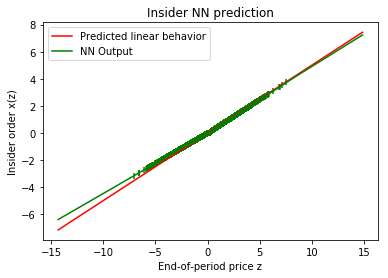

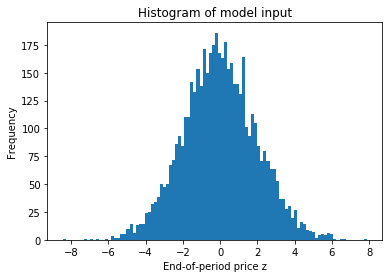

slope: 0.46987225309924896; intercept: 0.04752412810921659
slope_pred: 0.5; int_pred: 0.0
R_sq: 0.9995584555556054


In [6]:
z_sorted = np.sort(z_I)
z_sym = z_sorted[np.abs(z_sorted)<3]
#z_close = z_sorted[np.abs(z_sorted-2)<0.5]
bend = insider_model.predict([z_sym, np.zeros(np.size(z_sym))])
z_bend_r = z_sym[np.argmax(bend>0.05)] # argmax seeks first 'true'
z_bend_l = z_sym[np.argmin(bend<-0.05)-1] # argmin seeks first 'false'

## Plot I
dummy = np.zeros(n_I)
z_min = z_sorted[0]
z_max = z_sorted[-1]
z_test = np.linspace(z_min-np.linalg.norm(z_min-z_max)/2, z_max+np.linalg.norm(z_min-z_max)/2, num=1000)
plt.plot(z_test, z_test*slope_I+intercept_I, color='r')
plt.plot(z_test, insider_model.predict([z_test, np.zeros(1000)]),color='g')
plt.scatter(z_sorted,insider_model.predict([z_sorted, dummy]), marker='|', color='g')
if transaction_cost != 0:
    plt.axvline(z_bend_r, color='b', linestyle='--')
    plt.axvline(z_bend_l, color='b', linestyle='--')
    plt.axvline(0, color='grey', linestyle=':')
    plt.xticks(list(plt.xticks()[0]) + [int(z_bend_r*10)/10, int(z_bend_l*10)/10])
    print(f'Approximation: Left bend at: {z_bend_l}, right bend at: {z_bend_r}')
plt.xlabel('End-of-period price z')
plt.ylabel('Insider order x(z)')
plt.legend(['Predicted linear behavior','NN Output'])
plt.title('Insider NN prediction')
plt.savefig(f'{ whichstart}_I_{runname}_{whichconfig}_{N_loops}_{n_MM}_{epochs_MM}_{n_I}_{epochs_I}_{whichdist}_predictions.eps', format='eps')
plt.show()

# Plot 0
if transaction_cost != 0:
    plt.plot(z_sym, insider_model.predict([z_sym, np.zeros(np.size(z_sym))]), color='g')
    plt.axvline(z_bend_r, color='b', linestyle='--')
    plt.axvline(z_bend_l, color='b', linestyle='--')
    plt.axvline(0, color='grey', linestyle=':')
    plt.xticks(list(plt.xticks()[0]) + [int(z_bend_r*10)/10, int(z_bend_l*10)/10])
    plt.xlabel('End-of-period price z')
    plt.ylabel('Insider order x(z)')
    plt.title('Location of "bend" in the insider order function')
    plt.savefig(f'{ whichstart}_I_{runname}_{whichconfig}_{N_loops}_{n_MM}_{epochs_MM}_{n_I}_{epochs_I}_{whichdist}_bends.eps', format='eps')
    plt.show()

## Histogram 
plt.hist(z,bins=100)
plt.title('Histogram of model input')
plt.xlabel('End-of-period price z')
plt.ylabel('Frequency')
plt.savefig(f'{whichstart}_I_{runname}_{whichconfig}_{N_loops}_{n_MM}_{epochs_MM}_{n_I}_{epochs_I}_{whichdist}_hist.eps', format='eps')
plt.show()

z_min = mu_z-3*sigma_z # approx same as actual z_min
z_max = mu_z+3*sigma_z
z_test = np.linspace(z_min, z_max, 100)
x_test = np.squeeze(insider_model.predict([z_test, dummy])) # squeezing to get (100,1)->(100,)
reg = ss.linregress(z_test, x_test)
print(f'slope: {reg.slope}; intercept: {reg.intercept}\nslope_pred: {slope_I}; int_pred: {intercept_I}\nR_sq: {reg.rvalue}')